In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

### 1. 下載檔案並正規化

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. 檢視圖片內容

 deer   dog plane  deer


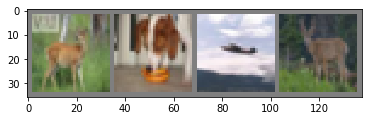

In [6]:
import matplotlib.pyplot as plt
import numpy as np

## 自己定義顯示圖像的function
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## 取得其中一個影像及標籤
dataiter = iter(trainloader)
images, labels = next(dataiter)

## 顯示圖像
imshow(torchvision.utils.make_grid(images))

## 顯示對應圖像的標籤
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 3. 定義CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 4. 定義損失函數和Optimizer  

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 5. 訓練神經網路

In [10]:
for epoch in range(2):  # 循環兩次

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 取得input
        inputs, labels = data

        # 梯度歸零
        optimizer.zero_grad()

        # 正向傳遞、反向傳遞、更新權重
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print狀態訊息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is done!!')

[1,  2000] loss: 2.188
[1,  4000] loss: 1.845
[1,  6000] loss: 1.665
[1,  8000] loss: 1.566
[1, 10000] loss: 1.517
[1, 12000] loss: 1.463
[2,  2000] loss: 1.399
[2,  4000] loss: 1.375
[2,  6000] loss: 1.347
[2,  8000] loss: 1.315
[2, 10000] loss: 1.275
[2, 12000] loss: 1.273
Training is done!!


### 6. 在訓練及上測試你的神經網路

GroundTruth:    cat  ship  ship plane


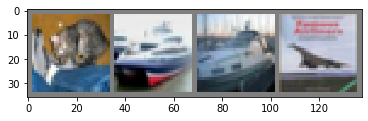

In [12]:
###先來看看這些測試用的圖片跟標籤是什麼
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
outputs = net(images)

In [14]:
## 部分測試集測試
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [15]:
## 完整測試集測試
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [16]:
## 各個類別的辨識表現

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 68 %
Accuracy of  bird : 36 %
Accuracy of   cat : 33 %
Accuracy of  deer : 58 %
Accuracy of   dog : 47 %
Accuracy of  frog : 64 %
Accuracy of horse : 65 %
Accuracy of  ship : 70 %
Accuracy of truck : 67 %
